# Potential Cheater Analysis

### Looking at another dataset for comparison, but potentially found a cheater.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from stockfish import Stockfish
import chess
import chess.engine
import math

In [2]:
engine = chess.engine.SimpleEngine.popen_uci("C:/Users/meinzecp/Downloads/stockfish_14.1_win_x64_avx2/stockfish_14.1_win_x64_avx2.exe")
stockfish = Stockfish('C:/Users/meinzecp/Downloads/stockfish_14.1_win_x64_avx2/stockfish_14.1_win_x64_avx2.exe')
stockfish.set_elo_rating(2600)
df = pd.read_csv('./chess_subsample.csv')

In [3]:
print(df.dtypes)
df.head(1)

game_id               int64
rated                  bool
turns                 int64
victory_status       object
winner               object
time_increment       object
white_id             object
white_rating          int64
black_id             object
black_rating          int64
moves                object
opening_code         object
opening_moves         int64
opening_fullname     object
opening_shortname    object
opening_response     object
opening_variation    object
dtype: object


,game_id,rated,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation
0,1,False,13,Out of Time,White,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5,Slav Defense: Exchange Variation,Slav Defense,NaN,Exchange Variation


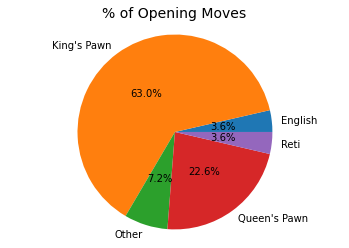

<Figure size 432x288 with 0 Axes>

In [4]:
# Remove any games that were cut short
df = df[df.turns >= 3]
df['moves_list'] = df.moves.apply(lambda x: x.split())

# Add features for opening moves and response to the opening move
df['opening_move'] = df.moves_list.apply(lambda x: x[0])
df['response'] = df.moves_list.apply(lambda x: x[1])

# Manually adding opening move names
df['opening_name'] = df.moves_list.apply(lambda x: 'King\'s Pawn' 
                                         if x[0] == 'e4' 
                                         else ('Queen\'s Pawn' 
                                               if x[0] == 'd4' 
                                               else ('English' 
                                                     if x[0] == 'c4' 
                                                     else ('Reti' 
                                                           if x[0] == 'Nf3' 
                                                           else 'Other'))))
df['rating_gap'] = abs(df['white_rating'] - df['black_rating'])

# Feature for determining if higher-rated player won
df['higher_rated_victory'] = np.where((df['winner'] == 'White') & (df['white_rating'] > df['black_rating']) | (df['winner'] == 'Black') & (df['black_rating'] > df['white_rating']), 1, 0)

# Generate function for getting different rating gaps
df['rating_gap_class'] = df.rating_gap.apply(lambda x: '0-50' 
                                             if (x <= 50) 
                                             else ('51-100' 
                                                   if (x > 50 and x <= 100) 
                                                   else ('101-150' 
                                                         if (x > 100 and x <= 150) 
                                                         else ('151-200' 
                                                               if (x > 150 and x <= 200) 
                                                               else ('201-250' 
                                                                     if (x > 200 and x <= 250) 
                                                                     else '>250')))))
df['white_victory'] = np.where(df['winner'] == 'White', 1, 0)

# Manually split into top 4 opening moves of white
english = df[df.opening_move == 'c4']
queens_pawn = df[df.opening_move == 'd4']
kings_pawn = df[df.opening_move == 'e4']
reti = df[df.opening_move == 'Nf3']

# Visualize most used openings
opening_data = df.groupby('opening_name')['game_id'].count()
plt.pie(x=opening_data, 
        autopct='%.1f%%', 
        labels=opening_data.keys(), 
        pctdistance=0.5)
plt.title('% of Opening Moves', fontsize=14)
plt.axis('equal')
plt.show()
plt.clf()

In [5]:
# Create new df that contains the count of who won
english_wins = english.groupby('winner')['game_id'].count()
queen_wins = queens_pawn.groupby('winner')['game_id'].count()
king_wins = kings_pawn.groupby('winner')['game_id'].count()
reti_wins = reti.groupby('winner')['game_id'].count()

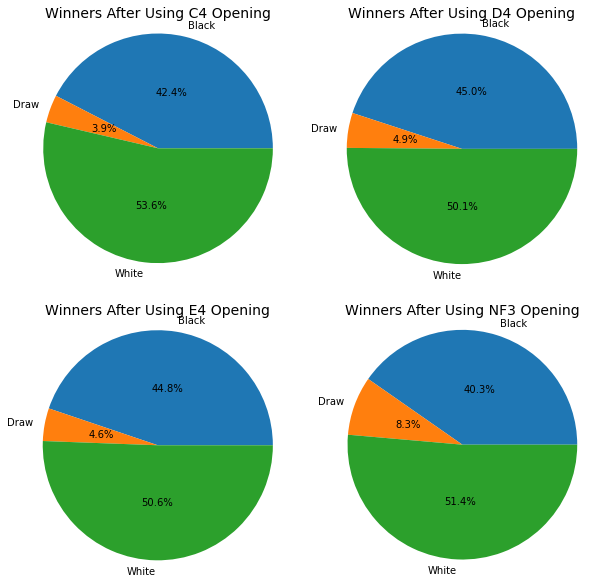

In [6]:
# Visualize wining results
pie, axs = plt.subplots(2,2, figsize=[10,10])

plt.subplot(2,2,1)
plt.pie(x=english_wins, 
        autopct="%.1f%%", 
        labels=english_wins.keys(), 
        pctdistance=0.5)
plt.title("Winners After Using C4 Opening", fontsize=14)
plt.axis('equal')

plt.subplot(2,2,2)
plt.pie(x=queen_wins, 
        autopct="%.1f%%", 
        labels=queen_wins.keys(), 
        pctdistance=0.5)
plt.title("Winners After Using D4 Opening", fontsize=14)
plt.axis('equal')

plt.subplot(2,2,3)
plt.pie(x=king_wins, 
        autopct="%.1f%%", 
        labels=king_wins.keys(), 
        pctdistance=0.5)
plt.title("Winners After Using E4 Opening", fontsize=14)
plt.axis('equal')

plt.subplot(2,2,4)
plt.pie(x=reti_wins, 
        autopct="%.1f%%", 
        labels=reti_wins.keys(), 
        pctdistance=0.5)
plt.title("Winners After Using NF3 Opening", fontsize=14)
plt.axis('equal')
plt.show()

In [7]:
# Create df with the total # of wins by the white pieces using top 4 common openings
df_grp_rating = df.groupby('opening_name')['higher_rated_victory'].sum()
df_grp_rating = df_grp_rating.to_frame()

# Add feature for the total # of games
df_grp_rating['totals'] = df.groupby('opening_name')['higher_rated_victory'].count()

# Add feature for draws/losses
df_grp_rating['losses_or_draws'] = df_grp_rating['totals'] - df_grp_rating['higher_rated_victory']
print(df_grp_rating.head(10))

              higher_rated_victory  totals  losses_or_draws
opening_name                                               
English                        426     714              288
King's Pawn                   7626   12499             4873
Other                          915    1434              519
Queen's Pawn                  2798    4486             1688
Reti                           424     722              298


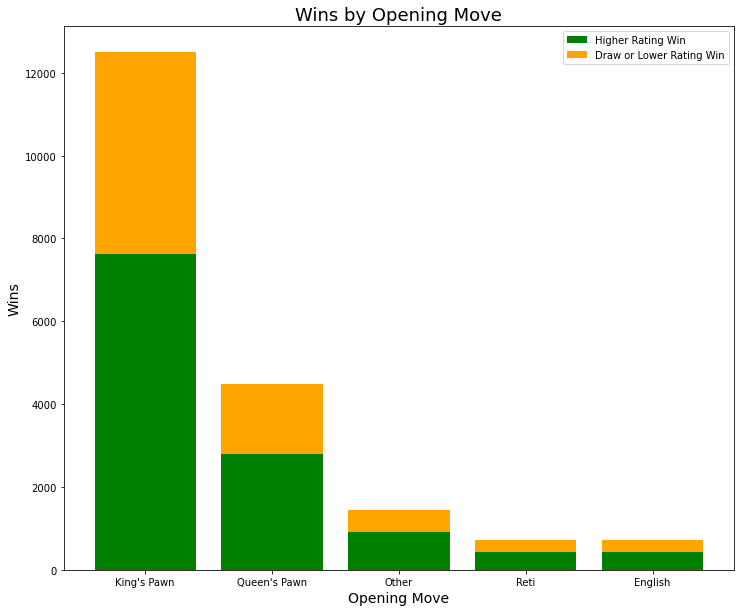

In [8]:
# Visualize which ratings dominate which opening
df_grp_rating = df_grp_rating.sort_values('totals', ascending=False)
fig, ax = plt.subplots(1, figsize=(12,10))

ax.bar([0,1,2,3,4], df_grp_rating['higher_rated_victory'], 
       label='Higher Rating Win', 
       color='green', 
       tick_label=df_grp_rating.index)
ax.bar([0,1,2,3,4], df_grp_rating['losses_or_draws'], 
       label='Draw or Lower Rating Win', 
       bottom=df_grp_rating['higher_rated_victory'], 
       color='orange')

ax.set_ylabel('Wins', fontsize=14)
ax.set_xlabel('Opening Move', fontsize=14)
ax.set_title('Wins by Opening Move', fontsize=18)
ax.legend()
plt.show()

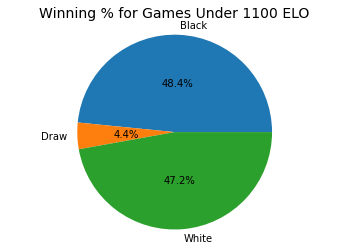

In [9]:
# Create df if players under 1100 ELO
num = 1100
df_under_num = df[(df.white_rating < num) & (df.black_rating < num)]

df_under_num_winners = df_under_num.groupby('winner')['game_id'].count()
df_under_num_winners

plt.pie(x=df_under_num_winners, 
        autopct="%.1f%%", 
        labels=df_under_num_winners.keys(), 
        pctdistance=0.5)
plt.title("Winning % for Games Under {} ELO".format(num), fontsize=14)
plt.axis('equal')
plt.show()

In [10]:
# Generate ddf for players playing as white
df_grp_username_white = df.groupby('white_id',as_index=False).agg({'white_victory':'sum', 'game_id':'count'})
df_grp_username_white.rename(columns={'white_victory':'white_victories', 'game_id':'white_games'}, inplace=True)
df_grp_username_white = df_grp_username_white.set_index('white_id')

# Generate df for players playing as black
df_grp_username_black = df.groupby('black_id',as_index=False).agg({'white_victory':'sum', 'game_id':'count'})
df_grp_username_black.rename(columns={'white_victory':'white_victories', 'game_id':'black_games'}, inplace=True)
df_grp_username_black = df_grp_username_black.set_index('black_id')

# Calculate number of black victories
df_grp_username_black['black_victories'] = df_grp_username_black.black_games - df_grp_username_black.white_victories
df_grp_username_black.drop('white_victories', axis=1, inplace=True)

# Merge the two dataframes, replacing NaN with 0.
df_grp_username = df_grp_username_white.join(df_grp_username_black)
df_grp_username = df_grp_username.fillna(0)

# Calculate win percentage
df_grp_username['victories'] = df_grp_username.white_victories + df_grp_username.black_victories
df_grp_username['games_played'] = df_grp_username.white_games + df_grp_username.black_games
df_grp_username['win_pct'] = df_grp_username.victories / df_grp_username.games_played


# Sort by people who have the highest win percentage
df_grp_username_sorted = df_grp_username.sort_values(by=['win_pct'], ascending=False)
df_grp_username_sorted.head(5)

,white_victories,white_games,black_games,black_victories,victories,games_played,win_pct
white_id,,,,,,,
rahza,1,1,0.0,0.0,1.0,1.0,1.0
houdini1ply,2,2,0.0,0.0,2.0,2.0,1.0
pakz91,1,1,0.0,0.0,1.0,1.0,1.0
holger1111,1,1,0.0,0.0,1.0,1.0,1.0
hola_yehmi,1,1,0.0,0.0,1.0,1.0,1.0


In [11]:
game_threshold = 24
df_grp_username_many_games = df_grp_username[(df_grp_username.games_played >= game_threshold)]
df_grp_username_many_games_sorted = df_grp_username_many_games.sort_values(by=['win_pct'], ascending=False)
df_grp_username_many_games_sorted.head(10)

,white_victories,white_games,black_games,black_victories,victories,games_played,win_pct
white_id,,,,,,,
chesswithmom,14,14,10.0,10.0,24.0,24.0,1.000000
siindbad,13,13,13.0,13.0,26.0,26.0,1.000000
smartduckduckcow,3,3,21.0,21.0,24.0,24.0,1.000000
chesscarl,18,18,28.0,27.0,45.0,46.0,0.978261
lzchips,12,13,13.0,13.0,25.0,26.0,0.961538
christina-a-11,14,15,11.0,11.0,25.0,26.0,0.961538
smilsydov,15,16,22.0,21.0,36.0,38.0,0.947368
doraemon61,18,19,23.0,21.0,39.0,42.0,0.928571
gmanderson,12,12,12.0,10.0,22.0,24.0,0.916667


In [12]:
df_carl = df[(df.white_id == 'chesscarl') | (df.black_id == 'chesscarl')]
df_carl.rated.unique()

array([ True])

In [13]:
# Get all the unique ids in the games chesscarl has played
print(df_carl.white_id.unique())
print(df_carl.black_id.unique())

['chilon' 'loebas' 'thelordoftheboard' 'lebbeusz2450' 'chesscarl'
 'angel2006' 'aca021' 'rigoberto_22' 'heisenberg3' 'vchess4' 'slobodan7'
 'fire_on_the_board' 'rodrigo-sagastegui' 'bdoq' 'hayki34' 'klemi'
 'mavrincbor' 'peshkach' 'ibonuribeetxebarria' 'foucheval' 'comped'
 'bshma' 'thorfabian' 'oilen1401' 'mahyir35' 'superii']
['chesscarl' 'christopho' 'kiterdekel' 'a_b_d_o' 'angel2006'
 'mario-panagiotis' 'grosschess' 'danielsor' 'sergey197316' 'anna1605'
 'wevertonsoares' 'withouttroble' 'g_king' 'krembrule' 'grewia'
 'ratnikmora' 'just_emza' 'gfinch' 'mahyir35']


In [14]:
# Calculate how many games that chesscarl was the higher-rated player
df_carl['carl_higher'] = np.where((df_carl['white_id'] == 'chesscarl') & 
                                  (df_carl['white_rating'] > df_carl['black_rating']) | 
                                  (df_carl['black_id'] == 'chesscarl') & 
                                  (df_carl['black_rating'] > df_carl['white_rating']), 1, 0)

# number of games that chesscarl was rated higher than their opponents
num_carl_higher = df_carl.carl_higher.sum()
print('Chesscarl is a higher rating in', num_carl_higher, 'of their', len(df_carl), 'games.')

Chesscarl is a higher rating in 43 of their 46 games.


C:\Users\meinzecp\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [15]:
df_carl_is_higher = df_carl[(df_carl.carl_higher == 1)]
df_carl_is_lower = df_carl[(df_carl.carl_higher == 0)]

print('Average rating above opponents when higher-rated:', df_carl_is_higher.rating_gap.mean())
print('Average rating below opponents when lower-rated:', df_carl_is_lower.rating_gap.mean())

Average rating above opponents when higher-rated: 355.48837209302326
Average rating below opponents when lower-rated: 68.0


In [16]:
# This code was developed with the help of multiple StackOverflow posts

def generate_similarity_to_engine(df, username, top_moves_num=3):
    # create an empty list to store the similarity between chesscarl's moves and a 2600-rated engine's top 3 moves
    engine_pct = []
    df_white = df[(df.white_id == username)]
    df_black = df[(df.black_id == username)]
    
    # loop through the moves in each white game, comparing to top engine moves
    for index, row in df_white.iterrows():
        similar_moves = 0
        moves_list = row['moves_list'] # get moves made by specified user
        board = chess.Board()
        for i in range(len(moves_list)):
            if i % 2 == 0:
                stockfish = Stockfish('C:/Users/meinzecp/Downloads/stockfish_14.1_win_x64_avx2/stockfish_14.1_win_x64_avx2.exe')
                stockfish.set_fen_position(board.fen()) #updates the current board position for stockfish
                engine_moves = stockfish.get_top_moves(top_moves_num) #returns a list of dictionaries containing the top moves
                
                # get the fen notation for the move made by the specified user
                board.push_san(moves_list[i])
                fen1 = board.fen()
                board.pop()
                # get the fen notation for all of the top moves and compare it to the fen notation of the move made by the user
                for dic in engine_moves:
                    board.push_san(dic['Move'])
                    fen2 = board.fen()
                    board.pop()
                    if fen1 == fen2:
                        similar_moves = similar_moves + 1 # add 1 to counter if fen position of engine = fen position of user
                board.push_san(moves_list[i]) # make white move
            else:
                board.push_san(moves_list[i]) # make black move (no need to compare these moves to the engine)
        similarity_pct = similar_moves / math.ceil(len(moves_list)/2)
        engine_pct.append(similarity_pct)
    
    # loop through the moves in each black game, comparing to top engine moves
    for index, row in df_black.iterrows():
        similar_moves = 0
        moves_list = row['moves_list']
        board = chess.Board()
        for i in range(len(moves_list)):
            if i % 2 == 1:
                stockfish = Stockfish('C:/Users/meinzecp/Downloads/stockfish_14.1_win_x64_avx2/stockfish_14.1_win_x64_avx2.exe')
                stockfish.set_fen_position(board.fen())
                engine_moves = stockfish.get_top_moves(top_moves_num)
                board.push_san(moves_list[i])
                fen1 = board.fen()
                board.pop()
                for dic in engine_moves:
                    board.push_san(dic['Move'])
                    fen2 = board.fen()
                    board.pop()
                    if fen1 == fen2:
                        similar_moves = similar_moves + 1
                board.push_san(moves_list[i])
            else:
                board.push_san(moves_list[i])
        similarity_pct = similar_moves / math.floor(len(moves_list)/2)
        engine_pct.append(similarity_pct)
    
    return engine_pct

In [17]:
chesscarl_game_engine_analysis = generate_similarity_to_engine(df, 'chesscarl', 4)
print(chesscarl_game_engine_analysis)

[1.0, 0.72, 0.9090909090909091, 1.0, 0.9523809523809523, 1.0, 0.9565217391304348, 0.7096774193548387, 0.9, 0.9047619047619048, 0.8571428571428571, 0.8, 0.8857142857142857, 0.9285714285714286, 0.8620689655172413, 0.9375, 0.9615384615384616, 0.9285714285714286, 0.8837209302325582, 0.896551724137931, 0.96, 0.9354838709677419, 0.9285714285714286, 0.9166666666666666, 1.0, 1.0, 0.7857142857142857, 0.8918918918918919, 0.7916666666666666, 0.8666666666666667, 0.9166666666666666, 0.9230769230769231, 0.9411764705882353, 0.8928571428571429, 0.9722222222222222, 0.7894736842105263, 0.75, 0.9130434782608695, 0.9090909090909091, 0.74, 1.0, 0.9166666666666666, 0.88, 0.8490566037735849, 0.9090909090909091, 0.6666666666666666]


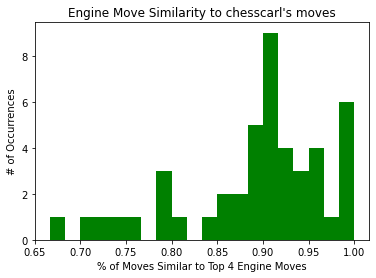

In [18]:
plt.hist(chesscarl_game_engine_analysis, bins=20, color='green')
plt.xlabel('% of Moves Similar to Top 4 Engine Moves')
plt.ylabel('# of Occurrences')
plt.title("Engine Move Similarity to chesscarl's moves")
plt.show()